In [62]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

from skimage import segmentation, graph
from skimage.color import label2rgb

import matplotlib.pyplot as plt
import os
import json
import shutil
import glob
import multiprocessing

from PIL import Image

import tensorflow as tf

Starting to match images to data...
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20
Number of matched rows: 1
Processed filename: 040318JK7_I_S1_20
Number of matched rows: 1
Shape of matched_df: (12, 4)
                        Image name          ID  Whole CA1  Average Whole CA1
0    022218JK0_C_S2_20xZpro_c1.png   022218JK0          7              4.000
1    02

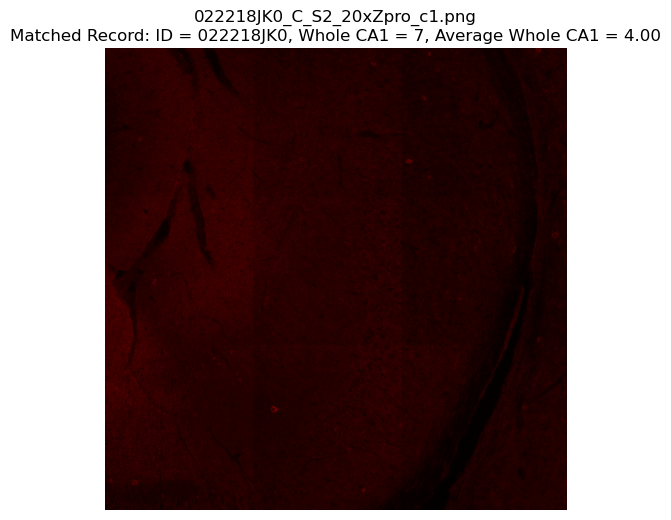

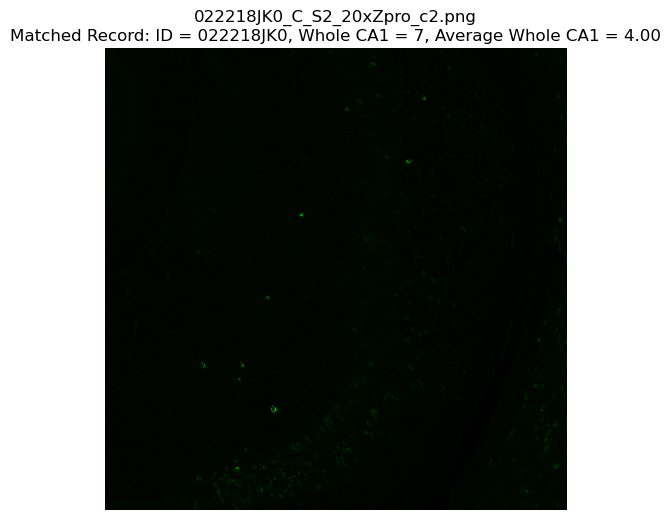

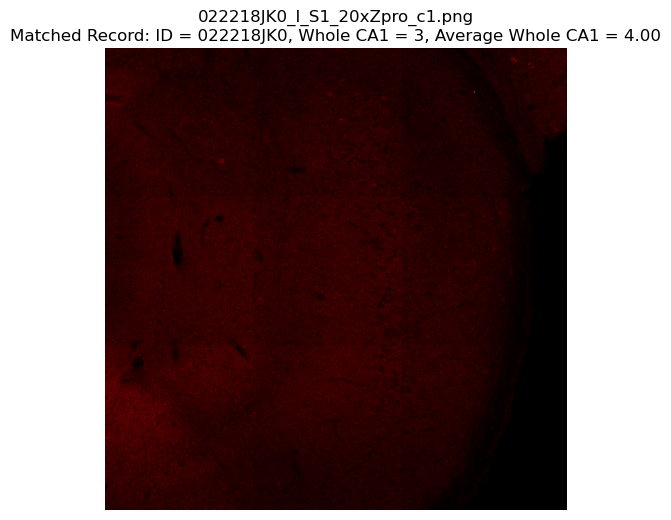

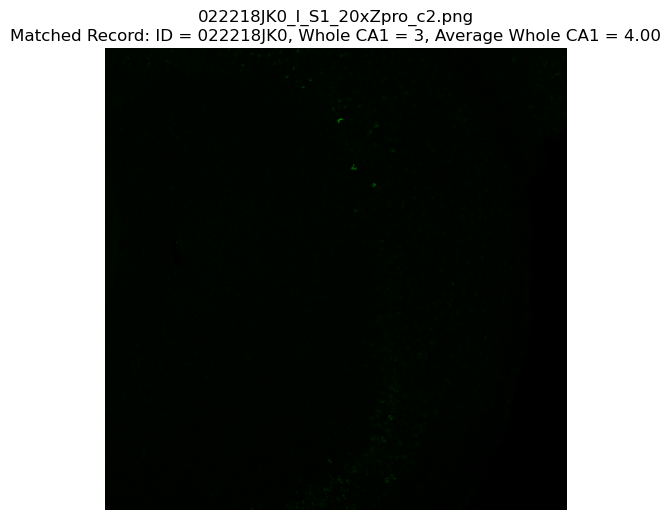

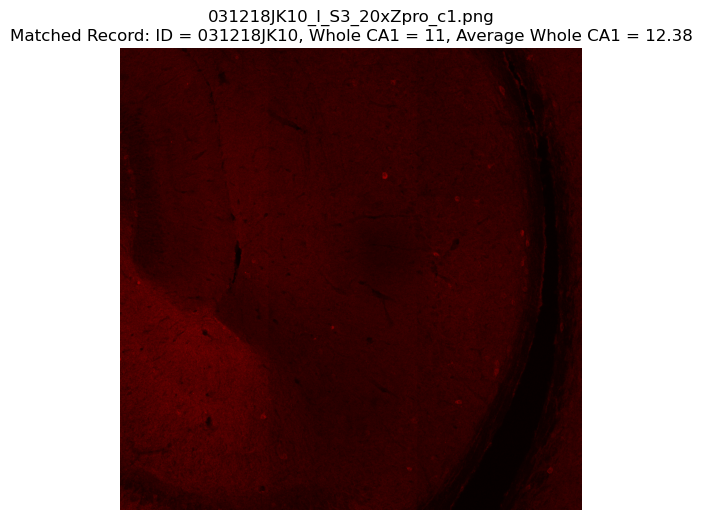

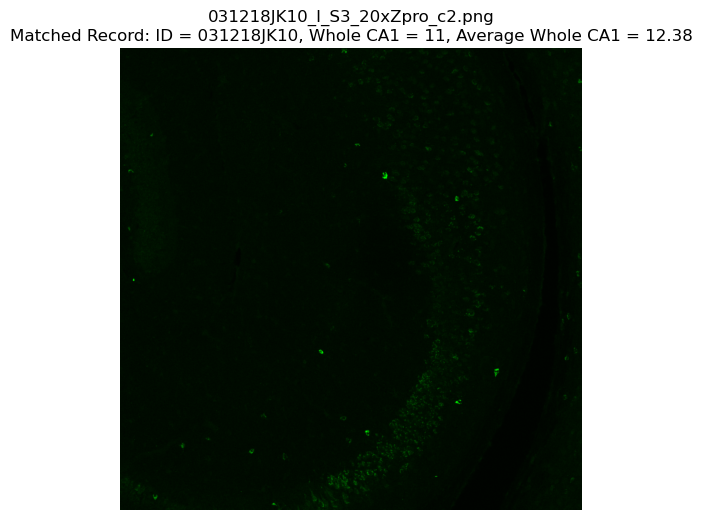

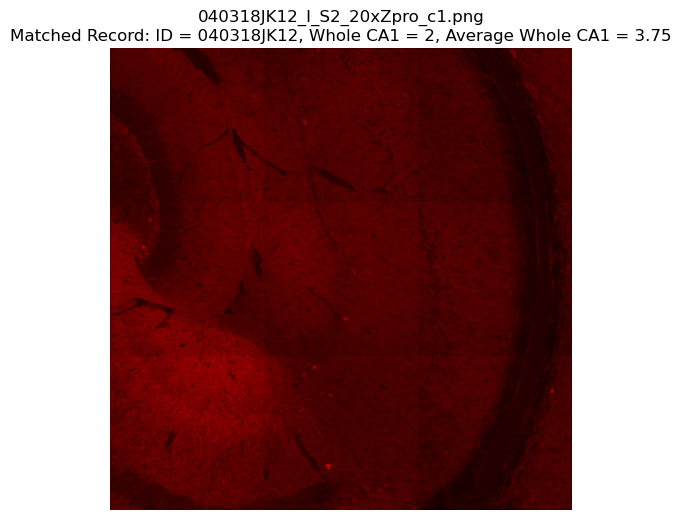

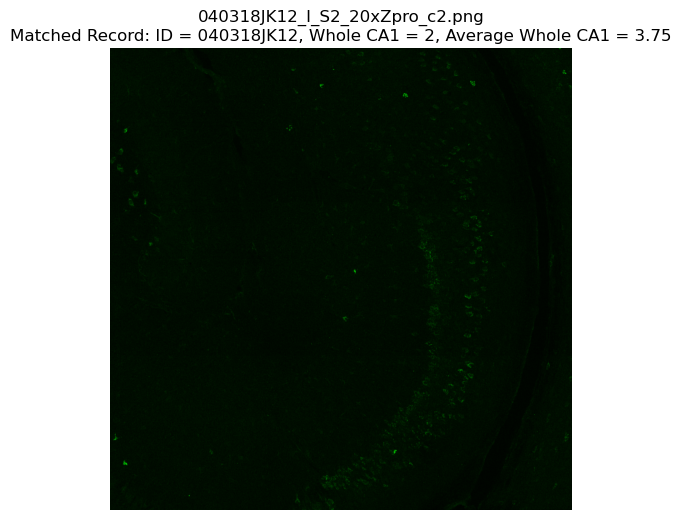

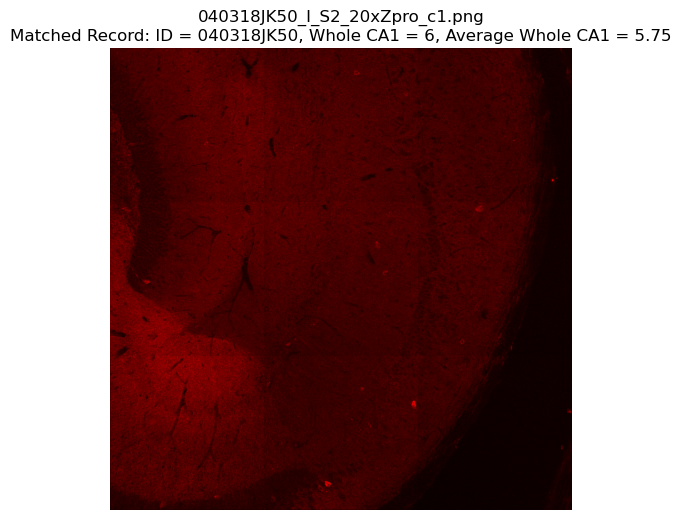

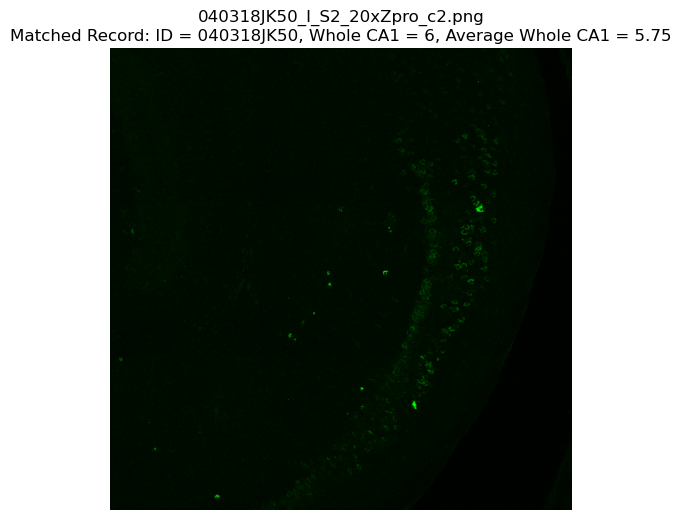

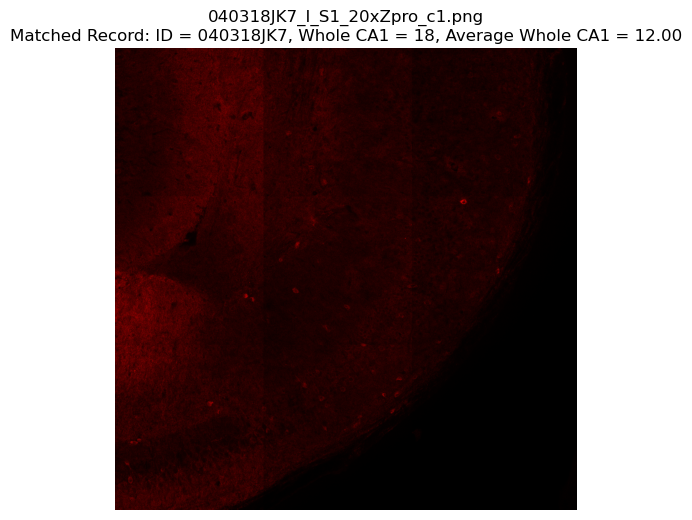

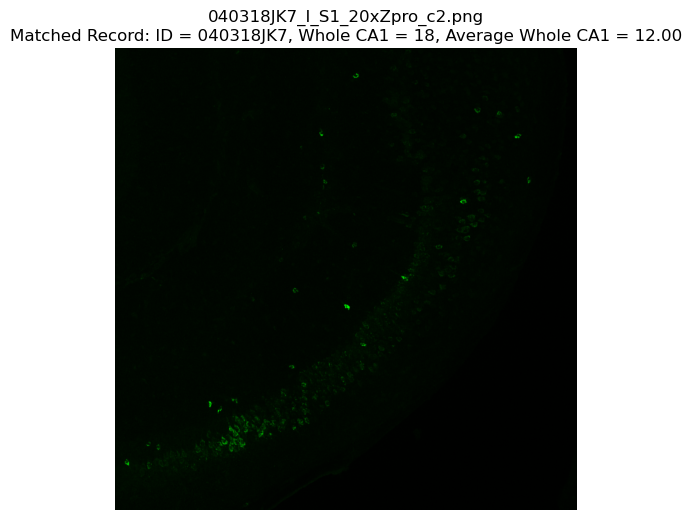

Files processed: 12, Matches found: 12


C:\Users\David\anaconda3\envs\myproject\lib\site-packages\openpyxl\worksheet\_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


           Image name          ID Treatment  Whole CA1
0   030618JK1_C_S1_20   030618JK1    SALINE         10
1   030618JK1_C_S2_20   030618JK1    SALINE         14
2   030618JK1_I_S1_20   030618JK1    SALINE          9
3   030618JK1_I_S2_20   030618JK1    SALINE          6
4  031218JK10_C_S1_20  031218JK10    SALINE         15
Starting to match images to data...
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_C_S2_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 022218JK0_I_S1_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 031218JK10_I_S3_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK12_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matched rows: 1
Processed filename: 040318JK50_I_S2_20
Number of matc

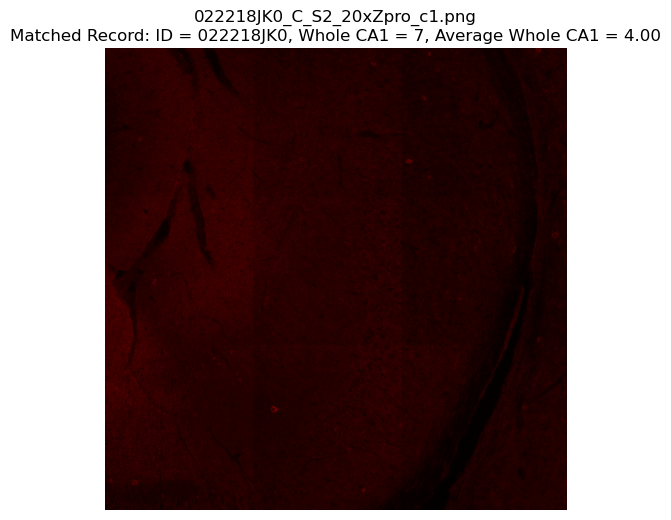

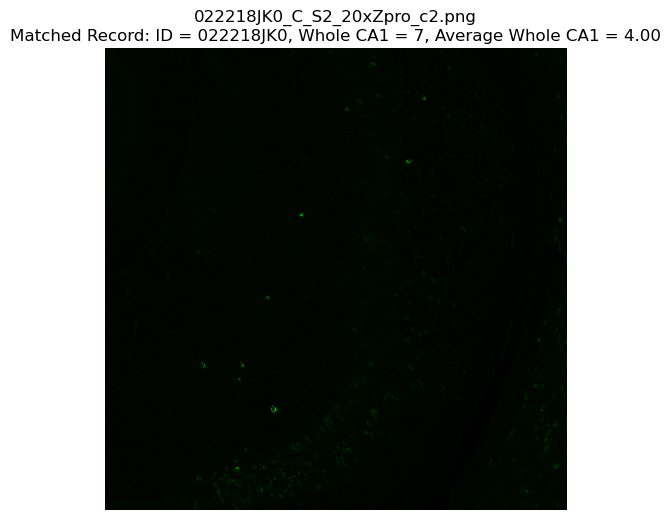

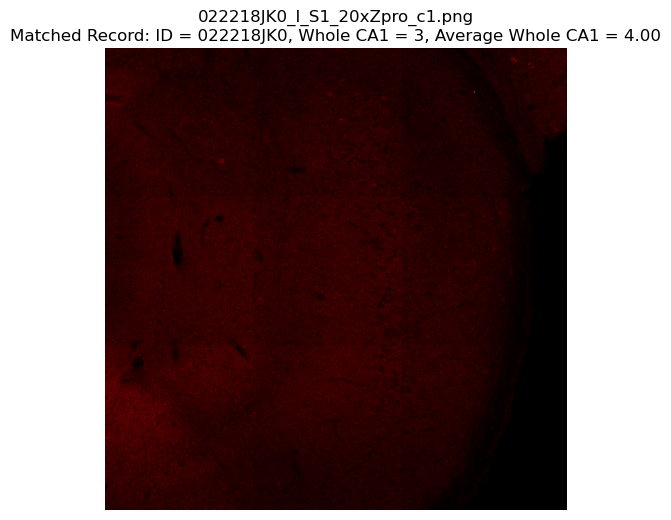

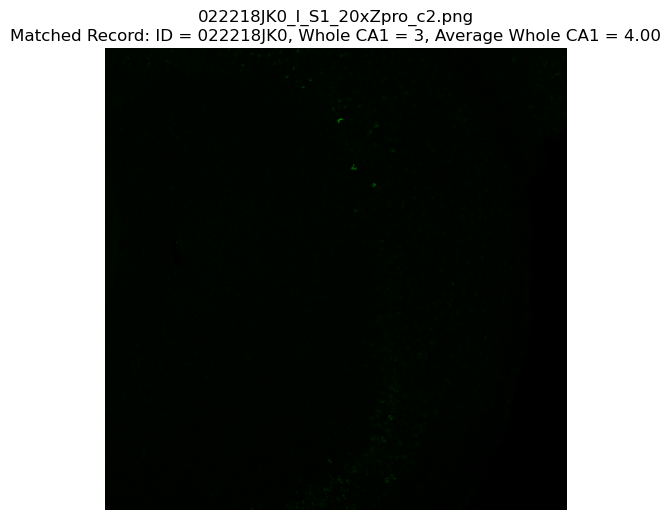

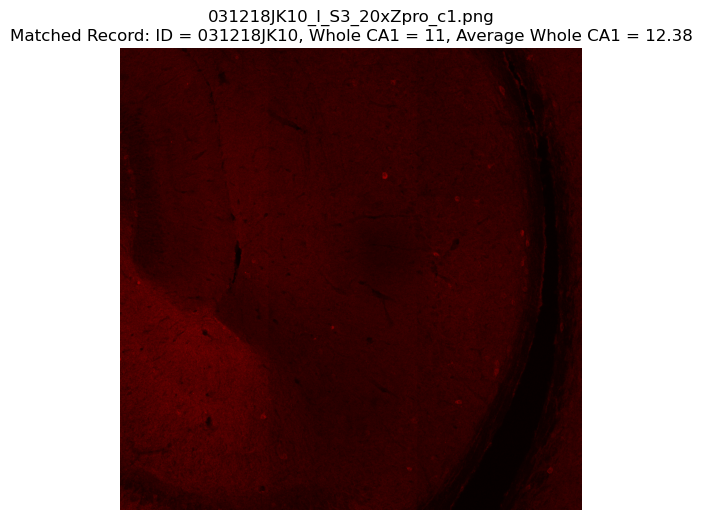

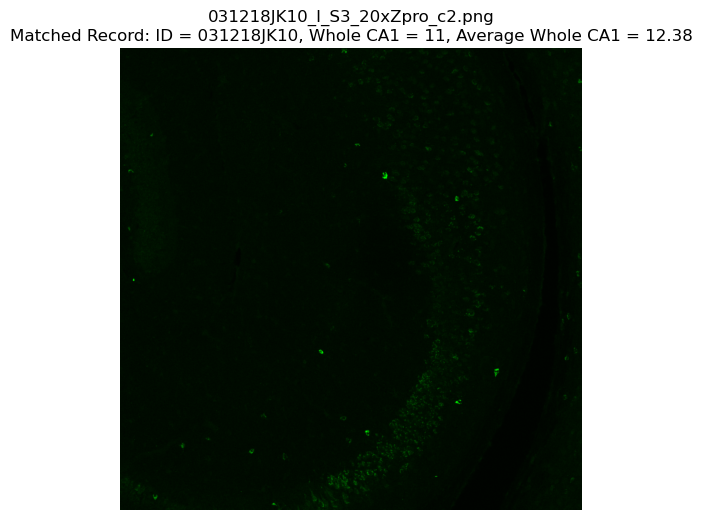

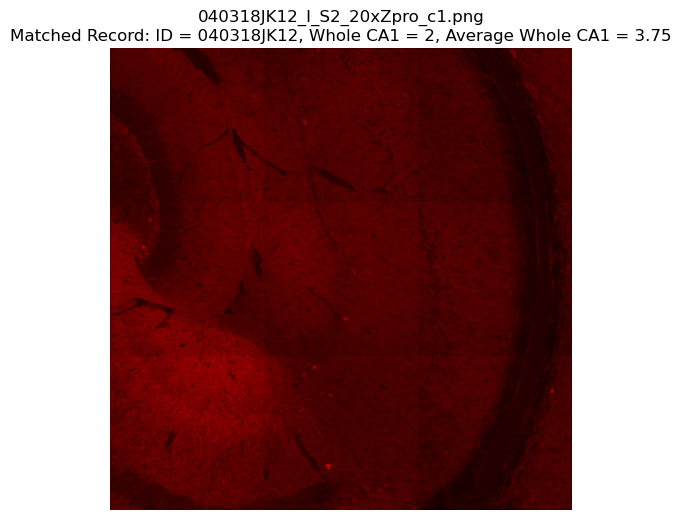

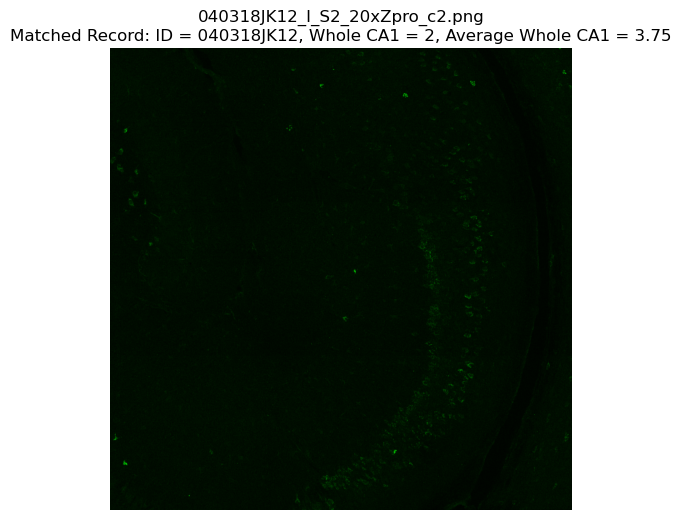

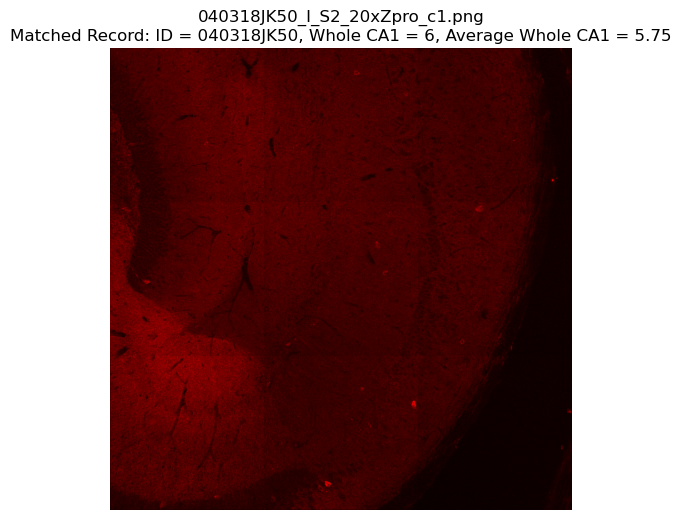

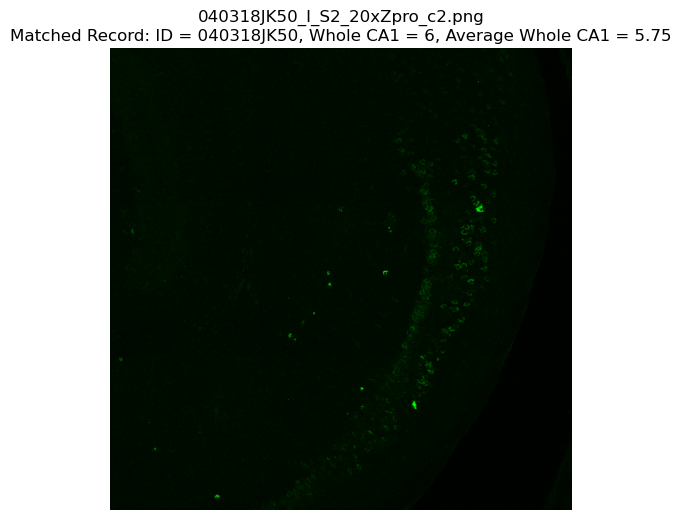

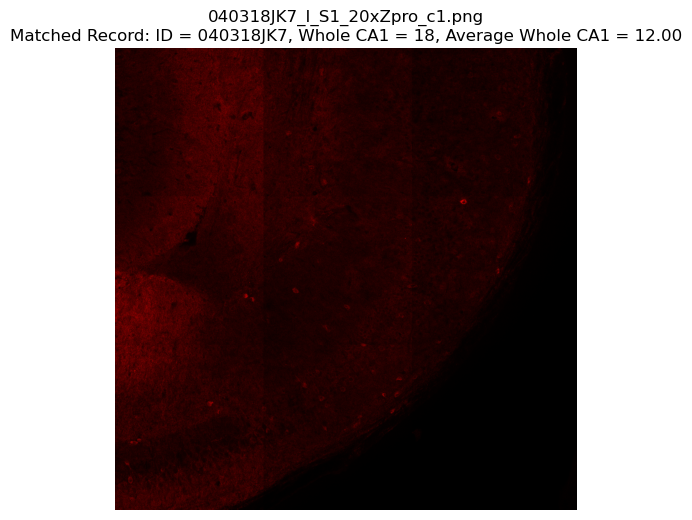

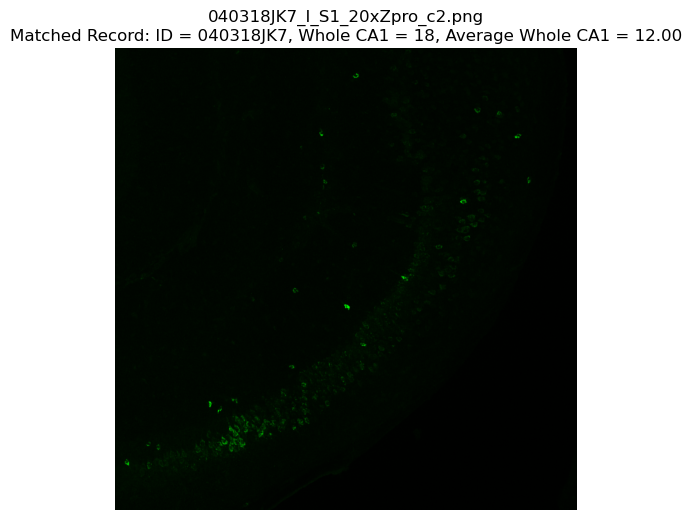

Files processed: 12, Matches found: 12


Image name          ID  Whole CA1  Average Whole CA1
0    022218JK0_C_S2_20xZpro_c1.png   022218JK0          7              4.000
1    022218JK0_C_S2_20xZpro_c2.png   022218JK0          7              4.000
2    022218JK0_I_S1_20xZpro_c1.png   022218JK0          3              4.000
3    022218JK0_I_S1_20xZpro_c2.png   022218JK0          3              4.000
4   031218JK10_I_S3_20xZpro_c1.png  031218JK10         11             12.375
5   031218JK10_I_S3_20xZpro_c2.png  031218JK10         11             12.375
6   040318JK12_I_S2_20xZpro_c1.png  040318JK12          2              3.750
7   040318JK12_I_S2_20xZpro_c2.png  040318JK12          2              3.750
8   040318JK50_I_S2_20xZpro_c1.png  040318JK50          6              5.750
9   040318JK50_I_S2_20xZpro_c2.png  040318JK50          6              5.750
10   040318JK7_I_S1_20xZpro_c1.png   040318JK7         18             12.000
11   040318JK7_I_S1_20xZpro_c2.png   040318JK7         18             12.000

In [63]:
def load_excel_data(filepath):
    df = pd.read_excel(filepath, header=1)
    df = df.iloc[:, [0, 1, 3, 14]].copy()
    df.columns = ['Image name', 'ID', 'Treatment', 'Whole CA1']
    df['Treatment'] = df['Treatment'].str.upper()
    df['Image name'] = df['Image name'].apply(lambda x: x.split('20')[0] + '20')
    df['Whole CA1'] = pd.to_numeric(df['Whole CA1'], errors='coerce').fillna(0)
    return df

def match_images_to_data(image_dir, df):
    # Compute the average 'Whole CA1' for each ID before matching
    average_ca1 = df.groupby('ID')['Whole CA1'].mean().reset_index()
    average_ca1.columns = ['ID', 'Average Whole CA1']
    df = df.merge(average_ca1, on='ID', how='left')
    
    print("Starting to match images to data...")
    files_found = matches_found = 0
    image_records = []

    for filename in os.listdir(image_dir):
        if filename.endswith('.png'):
            files_found += 1
            processed_filename = filename.split('20')[0] + '20'
            matched_rows = df[df['Image name'] == processed_filename]
            print("Processed filename:", processed_filename)  # Debug statement
            print("Number of matched rows:", len(matched_rows))  # Debug statement
    
            if not matched_rows.empty:
                matches_found += 1
                for _, row in matched_rows.iterrows():
                    image_records.append({
                        'Image name': filename,  # Corrected column name
                        'ID': row['ID'],
                        'Whole CA1': row['Whole CA1'],
                        'Average Whole CA1': row['Average Whole CA1']
                    })
            else:
                print(f"No match found for {filename}")
    
    matched_df = pd.DataFrame(image_records)
    print("Shape of matched_df:", matched_df.shape)

    if matched_df.empty:
        print("No images matched.")
    else:
        print(matched_df)

        # Display images with their matched record and average
        for _, record in matched_df.iterrows():
            image_path = os.path.join(image_dir, record['Image name'])
            display_matched_image(image_path, record)

    print(f"Files processed: {files_found}, Matches found: {matches_found}")
    return matched_df 

def display_matched_image(image_path, record):
    image = Image.open(image_path)
    plt.figure(figsize=(8, 6))
    plt.imshow(image)
    plt.title(f"{record['Image name']}\nMatched Record: ID = {record['ID']}, Whole CA1 = {record['Whole CA1']}, Average Whole CA1 = {record['Average Whole CA1']:.2f}")
    plt.axis('off')
    plt.show()

# Paths
excel_path = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\Capstone_histology_data.xlsx'
images_path = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages\\original_images'

matched_df = match_images_to_data(images_path, data_df) 
data_df = load_excel_data(excel_path)
print(data_df.head())
match_images_to_data(images_path, data_df)


In [64]:
def find_image_pairs(image_dir):
    """Identify pairs of images with 'c1' and 'c2' in their filenames sharing the same prefix."""
    files = os.listdir(image_dir)
    pairs = {}
    temp_dict = {}

    for file in files:
        if file.endswith('.png'):
            base_name = file.rsplit('_', 1)[0]  # Get the common prefix without the last segment
            suffix = file.split('_')[-1]  # Get the last segment, i.e., 'c1.png' or 'c2.png'

            # Ensure only 'c1' or 'c2' are considered
            if suffix in ['c1.png', 'c2.png']:
                # Map the base name to its respective 'c1' or 'c2' file
                if base_name not in temp_dict:
                    temp_dict[base_name] = {}
                temp_dict[base_name][suffix] = file

    # Build pairs from the temporary dictionary
    for base_name, suffixes in temp_dict.items():
        if 'c1.png' in suffixes and 'c2.png' in suffixes:
            pairs[suffixes['c1.png']] = suffixes['c2.png']
            print("Pair found:", suffixes['c1.png'], "with", suffixes['c2.png'])  # Debug statement

    return pairs

image_pairs = find_image_pairs(images_path)
print("Image pairs:", image_pairs)

Pair found: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png
Pair found: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png
Pair found: 031218JK10_I_S3_20xZpro_c1.png with 031218JK10_I_S3_20xZpro_c2.png
Pair found: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png
Pair found: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png
Pair found: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png
Image pairs: {'022218JK0_C_S2_20xZpro_c1.png': '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png': '022218JK0_I_S1_20xZpro_c2.png', '031218JK10_I_S3_20xZpro_c1.png': '031218JK10_I_S3_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png': '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png': '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png': '040318JK7_I_S1_20xZpro_c2.png'}


Overlaying image pairs...
Shape of matched_df: (12, 4)
Columns in matched_df: Index(['Image name', 'ID', 'Whole CA1', 'Average Whole CA1'], dtype='object')
Image names in dataset: ['022218JK0_C_S2_20xZpro_c1.png', '022218JK0_C_S2_20xZpro_c2.png', '022218JK0_I_S1_20xZpro_c1.png', '022218JK0_I_S1_20xZpro_c2.png', '031218JK10_I_S3_20xZpro_c1.png', '031218JK10_I_S3_20xZpro_c2.png', '040318JK12_I_S2_20xZpro_c1.png', '040318JK12_I_S2_20xZpro_c2.png', '040318JK50_I_S2_20xZpro_c1.png', '040318JK50_I_S2_20xZpro_c2.png', '040318JK7_I_S1_20xZpro_c1.png', '040318JK7_I_S1_20xZpro_c2.png']
Current pair 1: 022218JK0_C_S2_20xZpro_c1.png with 022218JK0_C_S2_20xZpro_c2.png


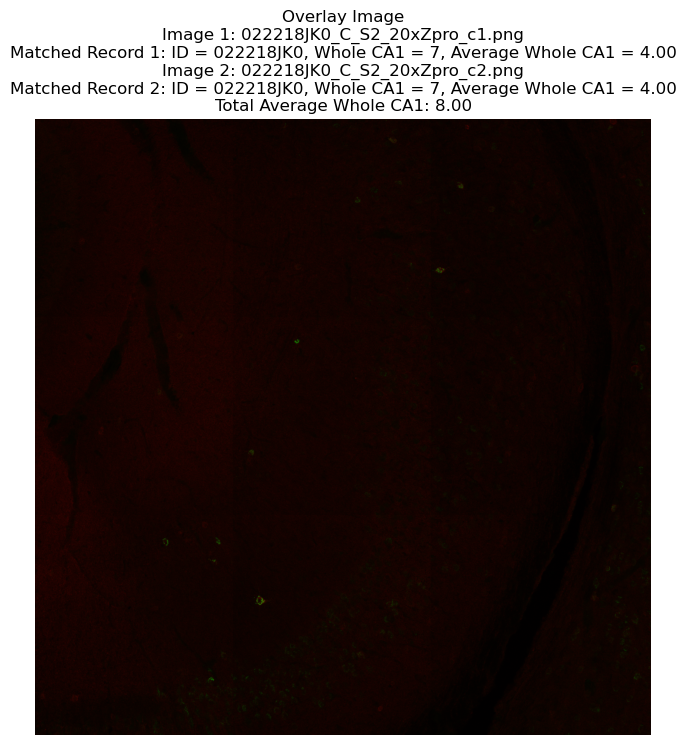

Processed pair 1/6
Current pair 2: 022218JK0_I_S1_20xZpro_c1.png with 022218JK0_I_S1_20xZpro_c2.png


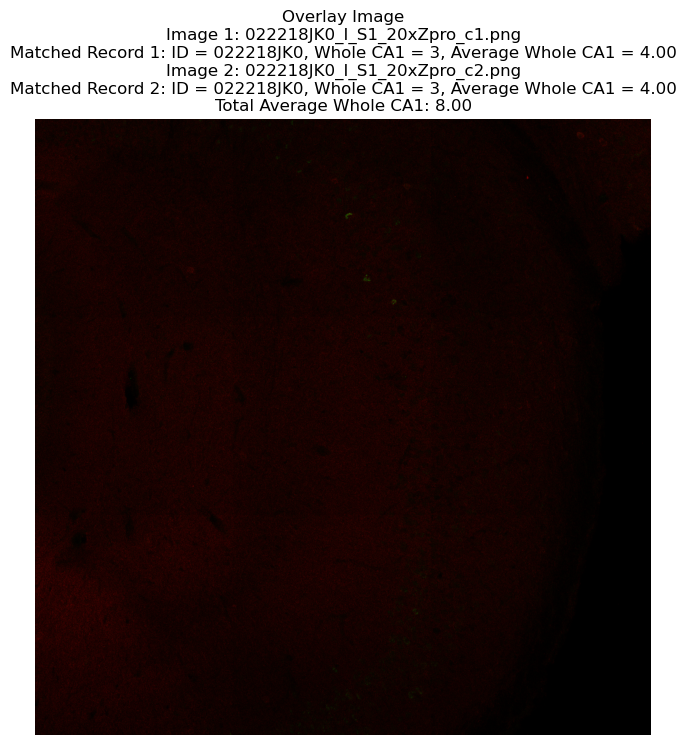

Processed pair 2/6
Current pair 3: 031218JK10_I_S3_20xZpro_c1.png with 031218JK10_I_S3_20xZpro_c2.png


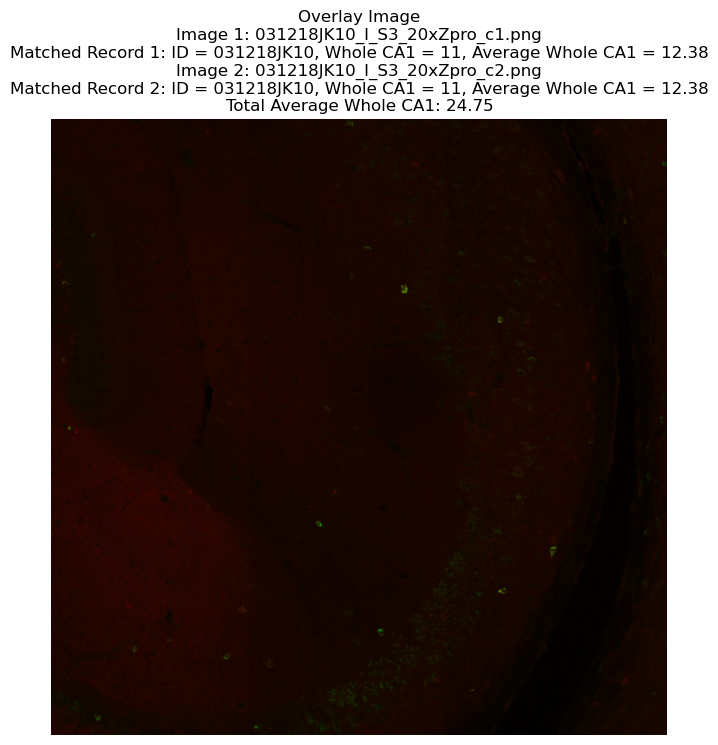

Processed pair 3/6
Current pair 4: 040318JK12_I_S2_20xZpro_c1.png with 040318JK12_I_S2_20xZpro_c2.png


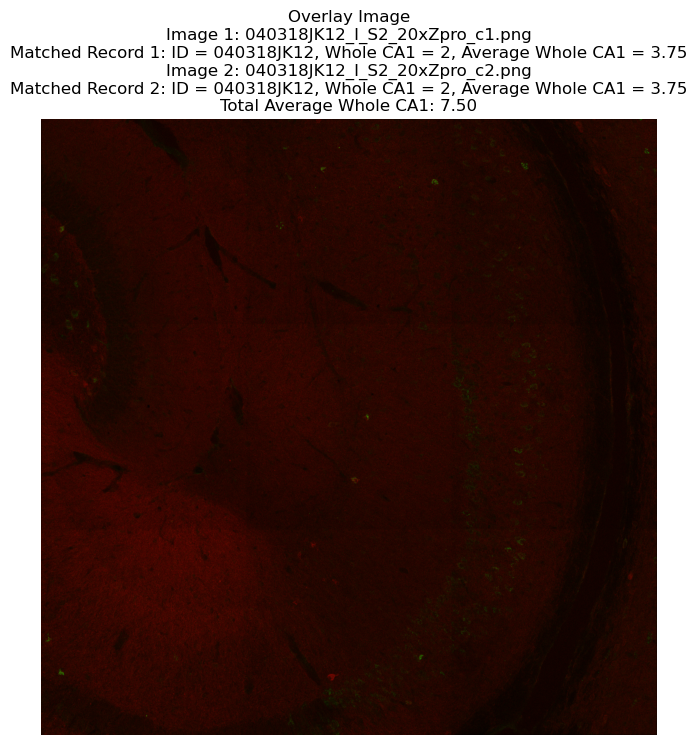

Processed pair 4/6
Current pair 5: 040318JK50_I_S2_20xZpro_c1.png with 040318JK50_I_S2_20xZpro_c2.png


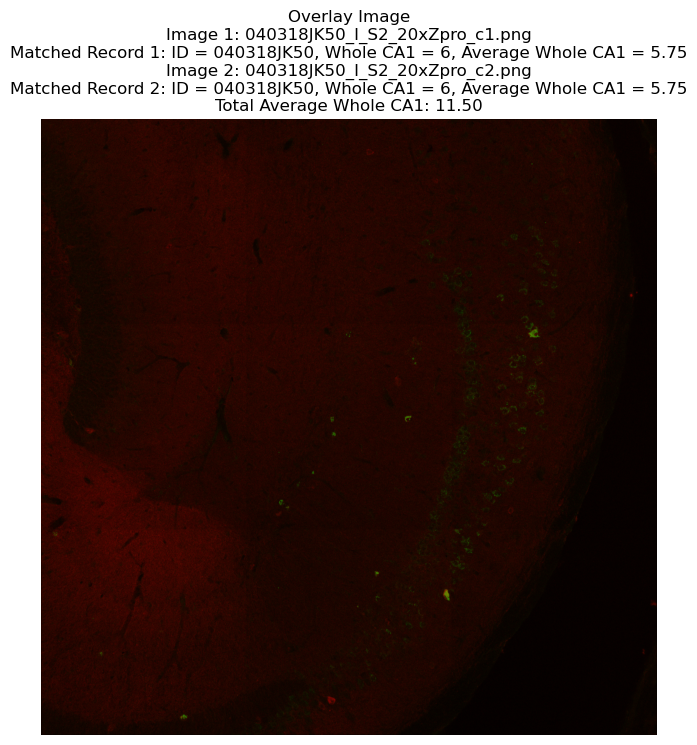

Processed pair 5/6
Current pair 6: 040318JK7_I_S1_20xZpro_c1.png with 040318JK7_I_S1_20xZpro_c2.png


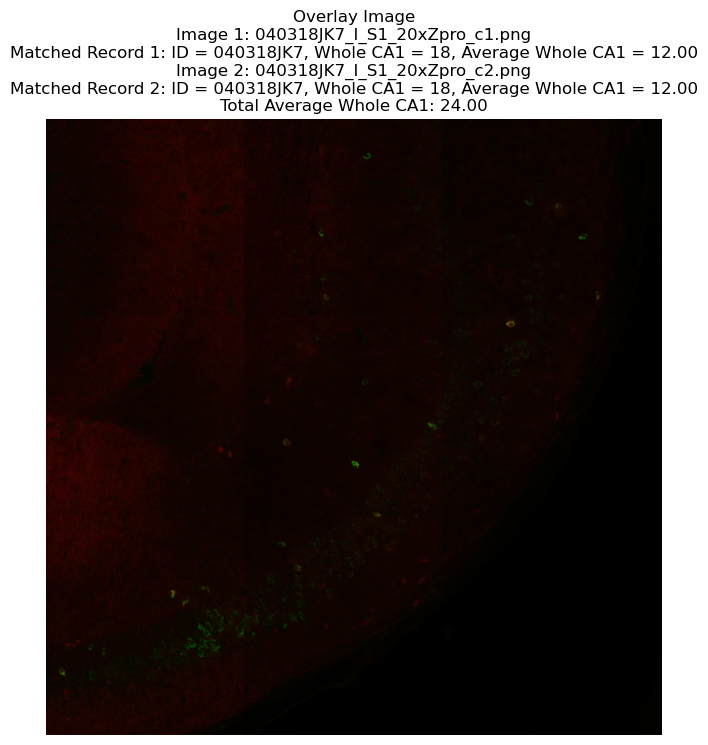

Processed pair 6/6
                                  Overlay Image Path  Total Average Whole CA1
0  C:\Users\David\Documents\Capstone\Final Projec...                     8.00
1  C:\Users\David\Documents\Capstone\Final Projec...                     8.00
2  C:\Users\David\Documents\Capstone\Final Projec...                    24.75
3  C:\Users\David\Documents\Capstone\Final Projec...                     7.50
4  C:\Users\David\Documents\Capstone\Final Projec...                    11.50
5  C:\Users\David\Documents\Capstone\Final Projec...                    24.00


In [75]:
def overlay_images(img1_path, img2_path, output_path, alpha=0.5):
    """Overlay two images with specified alpha for each."""
    img1 = Image.open(img1_path).convert("RGBA")
    img2 = Image.open(img2_path).convert("RGBA")

    # Resize images to match if they are not the same size
    if img1.size != img2.size:
        img1 = img1.resize(img2.size)
    img1_np = np.array(img1)
    img2_np = np.array(img2)

    # Overlay images
    overlay = cv2.addWeighted(img1_np, alpha, img2_np, 1 - alpha, 0)
    overlay_img = Image.fromarray(overlay)

    # Save the overlay image
    overlay_img.save(output_path)

    # Display the overlayed image
    return overlay_img

def display_overlayed_image(overlay_img, record1, record2):
    overlay = overlay_img  # Use the provided overlay image

    # Calculate the total Average Whole CA1 for the overlayed image
    total_average_ca1 = record1['Average Whole CA1'] + record2['Average Whole CA1']

    plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
    plt.imshow(overlay)
    plt.title(f"Overlay Image\n"
              f"Image 1: {record1['Image name']}\n"
              f"Matched Record 1: ID = {record1['ID']}, Whole CA1 = {record1['Whole CA1']}, Average Whole CA1 = {record1['Average Whole CA1']:.2f}\n"
              f"Image 2: {record2['Image name']}\n"
              f"Matched Record 2: ID = {record2['ID']}, Whole CA1 = {record2['Whole CA1']}, Average Whole CA1 = {record2['Average Whole CA1']:.2f}\n"
              f"Total Average Whole CA1: {total_average_ca1:.2f}")
    plt.axis('off')  # Hide axes to focus only on the image
    plt.show()

def overlay_image_pairs(image_pairs, input_dir, output_dir, matched_df):
    # Initialize a list to collect data for the DataFrame
    overlay_data = []
    
    total_pairs = len(image_pairs)
    print("Overlaying image pairs...")
    print("Shape of matched_df:", matched_df.shape)
    print("Columns in matched_df:", matched_df.columns)
    print("Image names in dataset:", matched_df['Image name'].tolist())

    for i, (img1_name, img2_name) in enumerate(image_pairs.items(), start=1):
        print(f"Current pair {i}: {img1_name} with {img2_name}")
        
        if img1_name not in matched_df['Image name'].values or img2_name not in matched_df['Image name'].values:
            print(f"No match found for {img1_name} or {img2_name} in matched_df")
            continue

        # Retrieve records
        img1_record = matched_df[matched_df['Image name'] == img1_name].iloc[0]
        img2_record = matched_df[matched_df['Image name'] == img2_name].iloc[0]

        # Calculate the total Average Whole CA1
        total_average_whole_ca1 = img1_record['Average Whole CA1'] + img2_record['Average Whole CA1']

        img1_path = os.path.join(input_dir, img1_name)
        img2_path = os.path.join(input_dir, img2_name)
        output_path = os.path.join(output_dir, f"{img1_name[:-4]}_overlay.png")

        overlay_img = overlay_images(img1_path, img2_path, output_path, alpha=0.5)
        display_overlayed_image(overlay_img, img1_record, img2_record)
        
        # Append the data to the list
        overlay_data.append({
            'Overlay Image Path': output_path,
            'Total Average Whole CA1': total_average_whole_ca1
        })

        print(f"Processed pair {i}/{total_pairs}")

    # Create a DataFrame from the collected data
    overlay_df = pd.DataFrame(overlay_data)
    return overlay_df
       
# Define paths and data
overlay_image_dir = 'C:\\Users\\David\\Documents\\Capstone\\Final Project_Eplipesy\\MouseNeuroImages\\overlay_images'

# Overlay image pairs
os.makedirs(overlay_image_dir, exist_ok=True)
overlay_df = overlay_image_pairs(image_pairs, images_path, overlay_output_path, matched_df)
print(overlay_df)

In [113]:
def filter_instances_by_color(image, red_threshold, green_threshold):
    """Apply color thresholds and return filtered image."""
    _, green_channel, red_channel = cv2.split(image)
    _, red_binary = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, green_binary = cv2.threshold(green_channel, green_threshold, 255, cv2.THRESH_BINARY)
    red_and_green = cv2.bitwise_and(red_binary, green_binary)
    filtered_image = cv2.bitwise_and(image, image, mask=red_and_green)
    return filtered_image

def filter_instances_by_size(image, min_area, max_area):
    """Apply size filtering to binary image and return filtered contours."""
    # Convert image to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Use adaptive thresholding
    binary_image = cv2.adaptiveThreshold(gray_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by size
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]
    
    return filtered_contours

def process_image_with_parameters(image_path, red_threshold, green_threshold):
    """Process an image with given red and green thresholds."""
    image = cv2.imread(image_path)
    if image is None:
        logging.warning(f"Image at {image_path} could not be loaded.")
        return None
    
    image = cv2.resize(image, (256, 256))
    filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
    return cv2.cvtColor(filtered_image, cv2.COLOR_BGR2GRAY).flatten()

def prepare_dataset(image_dir, overlay_df, red_threshold, green_threshold):
    print(overlay_df.columns)  # Debug: Check if 'Image name' is still a column
    X, y = [], []
    filenames = []
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])  # KeyError could occur here
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            X.append(features)
            y.append(row['Total Average Whole CA1'])
            filenames.append(row['Overlay Image Path'])
    return np.array(X), np.array(y), filenames
    
def perform_regression(image_dir, overlay_df, param_grid):
    """Perform regression analysis with grid search."""
    best_model = None
    best_score = float('inf')
    best_params = None

    for params in ParameterGrid(param_grid):
        logging.info(f"Testing parameters: {params}")
        X, y, _ = prepare_dataset(image_dir, overlay_df, params['red_threshold'], params['green_threshold'])

        if len(X) == 0:
            logging.warning("No data to fit the model.")
            continue

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
        model = RandomForestRegressor(n_estimators=params['n_estimators'], max_depth=params['max_depth'], random_state=42)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        mae = mean_absolute_error(y_test, predictions)

        if mae < best_score:
            best_score = mae
            best_params = params
            best_model = model
            logging.info(f"New best model with parameters: {best_params} and score: {best_score}")

    logging.info(f"Best Parameters: {best_params}")
    logging.info(f"Best Score: {best_score}")

    return best_model, best_params

param_grid = {
    'red_threshold': [55, 60],
    'green_threshold': [50, 55, 60],
    'n_estimators': [50],
    'max_depth': [None]
}

best_model, best_params = perform_regression(overlay_image_dir, overlay_df, param_grid)


2024-04-20 17:11:53,192 - INFO - Testing parameters: {'green_threshold': 50, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 55}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:11:56,924 - INFO - New best model with parameters: {'green_threshold': 50, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 55} and score: 8.969999999999999
2024-04-20 17:11:56,926 - INFO - Testing parameters: {'green_threshold': 50, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 60}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:12:00,800 - INFO - New best model with parameters: {'green_threshold': 50, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 60} and score: 4.869999999999999
2024-04-20 17:12:00,800 - INFO - Testing parameters: {'green_threshold': 55, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 55}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:12:04,510 - INFO - Testing parameters: {'green_threshold': 55, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 60}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:12:08,223 - INFO - Testing parameters: {'green_threshold': 60, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 55}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:12:12,398 - INFO - Testing parameters: {'green_threshold': 60, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 60}


Index(['Overlay Image Path', 'Total Average Whole CA1',
       'Predicted Total Average Whole CA1'],
      dtype='object')


2024-04-20 17:12:15,751 - INFO - Best Parameters: {'green_threshold': 50, 'max_depth': None, 'n_estimators': 50, 'red_threshold': 60}
2024-04-20 17:12:15,751 - INFO - Best Score: 4.869999999999999


2024-04-20 17:27:10,083 - INFO - Image: 022218JK0_C_S2_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 12.87
2024-04-20 17:27:10,320 - INFO - Image: 022218JK0_I_S1_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 12.87
2024-04-20 17:27:10,583 - INFO - Image: 031218JK10_I_S3_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 20.19
2024-04-20 17:27:10,890 - INFO - Image: 040318JK12_I_S2_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 12.87
2024-04-20 17:27:11,168 - INFO - Image: 040318JK50_I_S2_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 11.755
2024-04-20 17:27:11,394 - INFO - Image: 040318JK7_I_S1_20xZpro_c1_overlay.png, Predicted Total Average Whole CA1: 19.41


                       Overlay Image Path  Total Average Whole CA1  \
0   022218JK0_C_S2_20xZpro_c1_overlay.png                     8.00   
1   022218JK0_I_S1_20xZpro_c1_overlay.png                     8.00   
2  031218JK10_I_S3_20xZpro_c1_overlay.png                    24.75   
3  040318JK12_I_S2_20xZpro_c1_overlay.png                     7.50   
4  040318JK50_I_S2_20xZpro_c1_overlay.png                    11.50   
5   040318JK7_I_S1_20xZpro_c1_overlay.png                    24.00   

   Predicted Total Average Whole CA1  
0                             12.870  
1                             12.870  
2                             20.190  
3                             12.870  
4                             11.755  
5                             19.410  


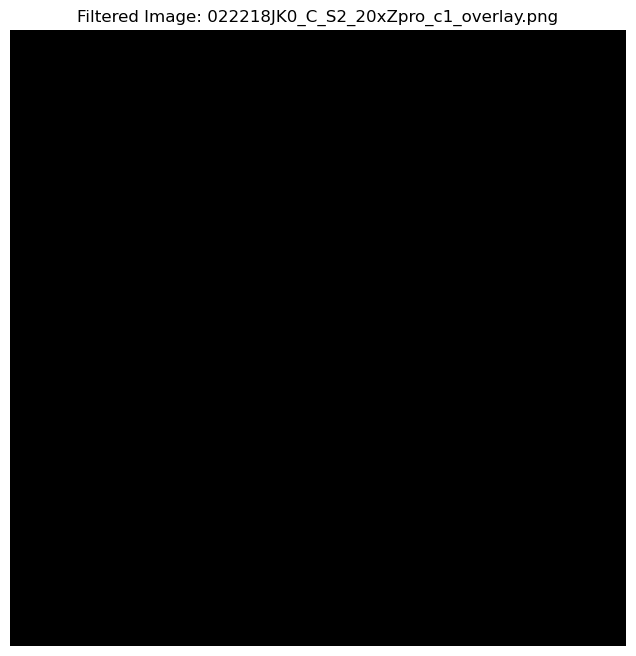

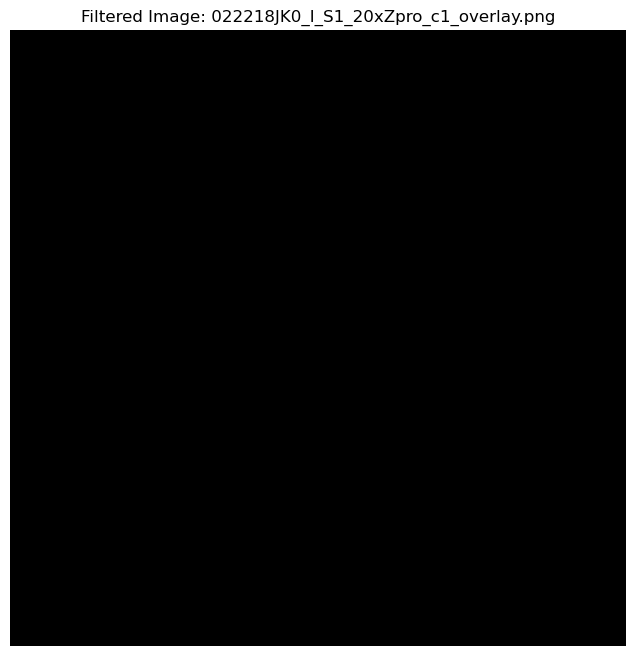

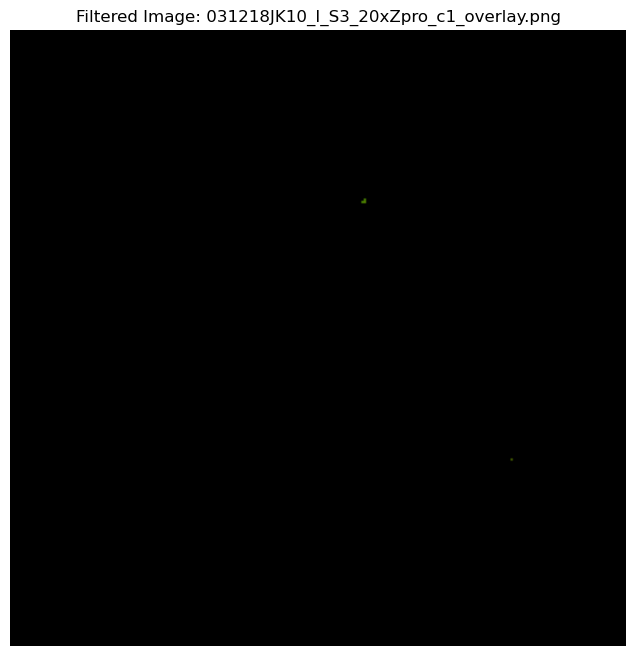

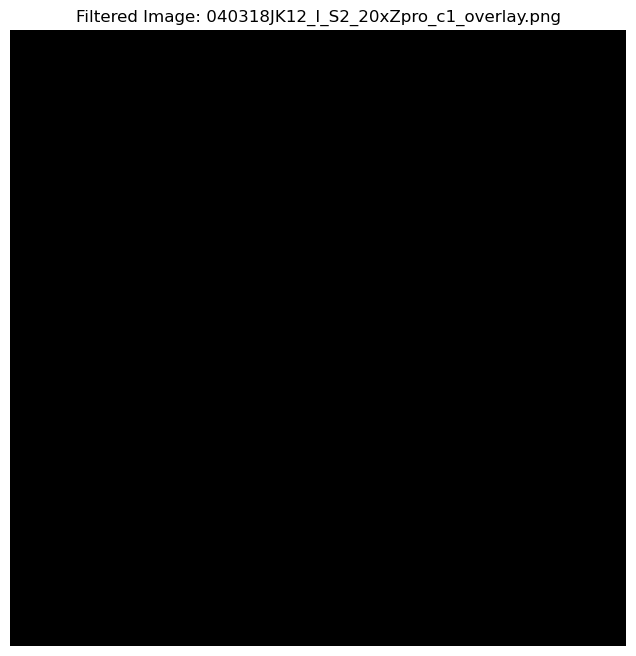

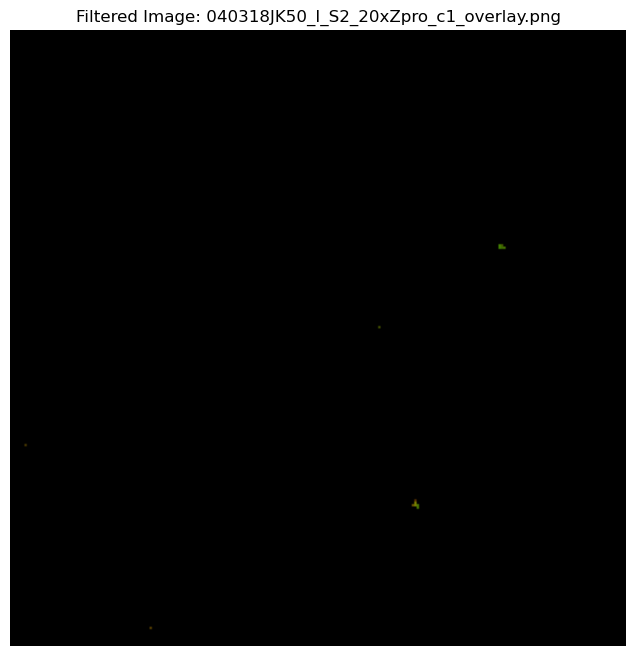

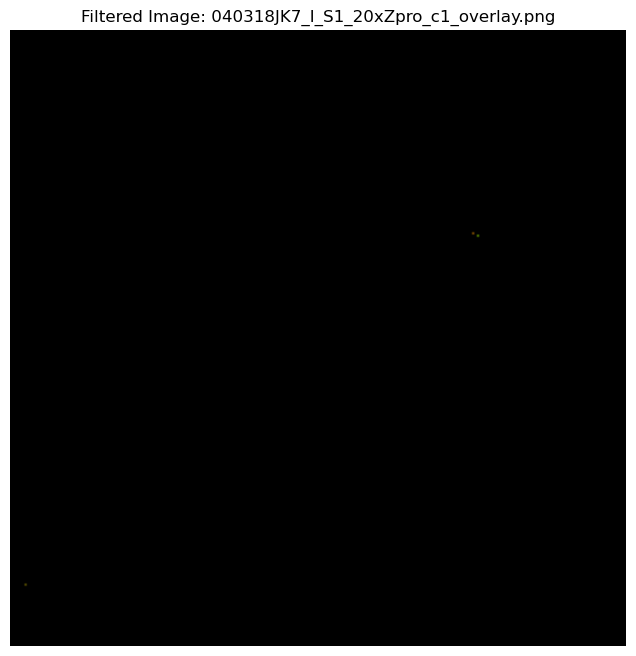

In [124]:
def predict_all_images(image_dir, overlay_df, best_model, red_threshold, green_threshold):
    # Create a new column for the predicted values initialized with NaNs
    overlay_df['Predicted Total Average Whole CA1'] = np.nan
    
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])
        features = process_image_with_parameters(image_path, red_threshold, green_threshold)
        if features is not None:
            # Predict the number of instances for the current image
            predicted_instances = best_model.predict([features])[0]
            # Add the prediction to the new column in the dataframe
            overlay_df.at[index, 'Predicted Total Average Whole CA1'] = predicted_instances
            logging.info(f"Image: {row['Overlay Image Path']}, Predicted Total Average Whole CA1: {predicted_instances}")

    return overlay_df

# Assuming perform_regression has already been run and best_model, best_params are available
overlay_df_with_predictions = predict_all_images(
    overlay_image_dir,
    overlay_df,
    best_model,
    best_params['red_threshold'],
    best_params['green_threshold']
)

# Now, overlay_df_with_predictions contains the original data along with a new column for predictions
# Extracting just the image name from the full path in the 'Overlay Image Path' column
overlay_df_with_predictions['Overlay Image Path'] = overlay_df_with_predictions['Overlay Image Path'].apply(lambda x: os.path.basename(x))

print(overlay_df_with_predictions)

def visualize_filtered_images(image_dir, overlay_df, red_threshold, green_threshold):
    for index, row in overlay_df.iterrows():
        image_path = os.path.join(image_dir, row['Overlay Image Path'])
        image = cv2.imread(image_path)
        if image is None:
            logging.warning(f"Image at {image_path} could not be loaded.")
            continue
        
        # Resize the image for visualization if needed
        image = cv2.resize(image, (256, 256))
        
        # Apply color filtering
        filtered_image = filter_instances_by_color(image, red_threshold, green_threshold)
        
        # Display the filtered image
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(filtered_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Filtered Image: {row['Overlay Image Path']}")
        plt.axis('off')
        plt.show()

# Assuming overlay_df and overlay_image_dir are defined
visualize_filtered_images(overlay_image_dir, overlay_df, best_params['red_threshold'], best_params['green_threshold'])

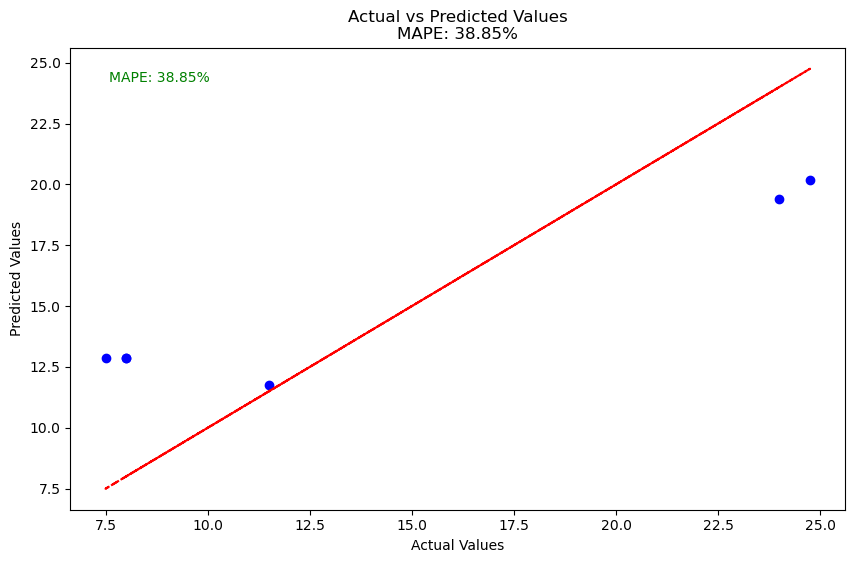

In [123]:
def visualize_predictions(actual_values, predicted_values):
    # Calculate Mean Absolute Percentage Error (MAPE)
    mape = np.mean(np.abs((actual_values - predicted_values) / actual_values)) * 100
    
    # Plot the actual vs predicted values
    plt.figure(figsize=(10, 6))
    plt.scatter(actual_values, predicted_values, color='blue')
    plt.plot(actual_values, actual_values, color='red', linestyle='--')
    plt.title(f'Actual vs Predicted Values\nMAPE: {mape:.2f}%')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    
    # Annotate the MAPE value on the plot
    plt.text(0.05, 0.95, f'MAPE: {mape:.2f}%', transform=plt.gca().transAxes, va='top', ha='left', color='green')
    
    plt.show()


# Extract actual and predicted values from overlay_df_with_predictions
actual_values = overlay_df_with_predictions['Total Average Whole CA1']
predicted_values = overlay_df_with_predictions['Predicted Total Average Whole CA1']

# Visualize the predictions
visualize_predictions(actual_values, predicted_values)

In [45]:
def filter_instances_by_color(image, red_threshold, green_threshold):
    """ Filter instances where both red and green channels exceed the specified brightness thresholds """
    # Split the image into its channel components
    blue_channel, green_channel, red_channel = cv2.split(image)
    
    # Apply a threshold to the red and green channels
    _, red_binary = cv2.threshold(red_channel, red_threshold, 255, cv2.THRESH_BINARY)
    _, green_binary = cv2.threshold(green_channel, green_threshold, 255, cv2.THRESH_BINARY)
    
    # Perform a bitwise AND to find where both red and green are present
    red_and_green = cv2.bitwise_and(red_binary, green_binary)
    
    # Keep only the regions of interest from the original image
    filtered_image = cv2.bitwise_and(image, image, mask=red_and_green)
    
    return filtered_image

def count_instances_adaptive_with_size_filtering(image_path, min_area, max_area):
    # Load the image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        raise FileNotFoundError(f"The image at {image_path} was not found.")
    
    # Use adaptive thresholding to account for varying lighting conditions
    binary_image = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                         cv2.THRESH_BINARY, 11, 2)
    
    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
    # Filter contours by size
    filtered_contours = [cnt for cnt in contours if min_area <= cv2.contourArea(cnt) <= max_area]
    
    # Create an output image for visualizing the contours
    visual_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(visual_image, filtered_contours, -1, (0, 255, 0), 2)
    
    return len(filtered_contours), binary_image, visual_image